-----------
Initializing structure...
time for choose_chunkdivision = 0.000437975 s


Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (20,20,20)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (20,20,20)
time for set_epsilon = 0.0347941 s
-----------
creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


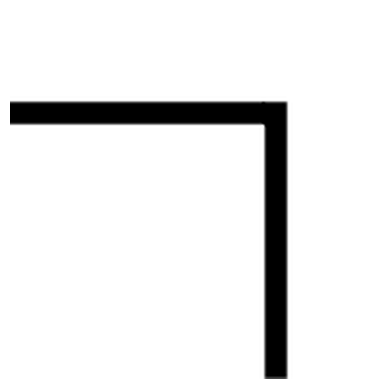

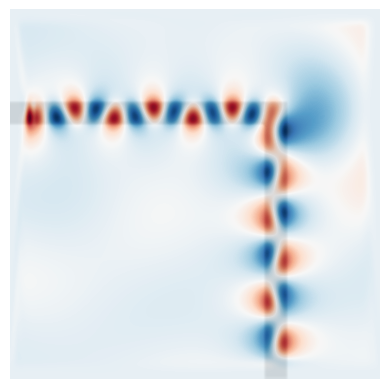

In [ ]:
import meep as mp
import matplotlib.pyplot as plt

cell = mp.Vector3(16,16,0)
geometry = [mp.Block(mp.Vector3(12,1,mp.inf),
                    center=mp.Vector3(-2.5,-3.5),
                    material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1,12,mp.inf),
                    center=mp.Vector3(3.5,2),
                    material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10

sources = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                    component=mp.Ez,
                    center=mp.Vector3(-7,-3.5),
                    size=mp.Vector3(0,1))]

sim = mp.Simulation(cell_size=cell, 
                    boundary_layers=pml_layers, 
                    geometry=geometry, 
                    sources=sources, 
                    resolution=resolution)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
        until=200)


eps_data = sim.get_array(center=mp.Vector3(), 
                        size=cell, 
                        component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()

ez_data = sim.get_array(center=mp.Vector3(), 
                        size=cell, 
                        component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

In [ ]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

mp.verbosity(0)
seed=240
np.random.seed(seed)
Si = np.Medium(index=3.4)
SiO2 = np.Medium(index=1.44)

resolution = 20

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

# source(Gaussian pulse)
fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [-1, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency = fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]